## Reproduction of Figure 3

This notebook reproduces the values in Figure 3.

In [1]:
import sys
sys.path.append("../../scripts")
import json
import pandas
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('../../data/Defects4J/all_d4j_crashes.txt') as f:
    jcrashpack_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

with open('../../data/Defects4J/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

In [3]:
def evaluate(raw_result, only_crash=False):
    rows = []
    
    for bug_id, test_exec_results in raw_result.items():
        if bug_id in invalid_bugs:
            continue
        if only_crash and bug_id not in jcrashpack_bugs:
            continue
            
        for i, (fname, res) in enumerate(test_exec_results.items()):
            javalang_parse_error = False
            is_compile_error = False
            is_runtime_error = False
            buggy_version_failing = False
            fixed_version_failing = False
            success = False

            if isinstance(res, str):
                javalang_parse_error = True 
            elif res['buggy']['compile_error'] or res['fixed']['compile_error']:
                is_compile_error = True
            elif res['buggy']['runtime_error'] or res['fixed']['runtime_error']:
                is_runtime_error = True
            else:
                if res['buggy']['autogen_failed']:
                    buggy_version_failing = True
                if res['fixed']['autogen_failed']:
                    fixed_version_failing = True
                if buggy_version_failing and (not fixed_version_failing):
                    success = True
            
            rows.append({
                'project': bug_id.split('_')[0],
                'bug_id': bug_id,
                'test_no': i+1,
                'javalang_parse_error': javalang_parse_error,
                'is_compile_error': is_compile_error,
                'is_runtime_error': is_runtime_error,
                'buggy_version_failing': buggy_version_failing,
                'fixed_version_failing': fixed_version_failing,
                'fname': fname,
                'success': success,
            })
    
    return pandas.DataFrame(rows)

In [4]:
RESULT_PATH = '../../results/example2_n50.json'

In [5]:
with open(RESULT_PATH) as f:
    eval_df = evaluate(json.load(f))

In [6]:
def key_at_n(key):
    succ_at_try = defaultdict(list)
    for idx in range(50):
        succ_at_try[idx] = set(eval_df[(eval_df.test_no == (idx+1)) & 
                                       (eval_df[key] > 0)]['bug_id'])

    x, ys = [], []
    org_list = list(range(50))
    x = org_list[:]
    for sim_idx in range(1000):
        random.shuffle(org_list)
        y = []
        succ_set = set()
        for idx in org_list:
            succ_set |= set(succ_at_try[idx])
            y.append(len(succ_set))
        ys.append(y)
    return np.array(ys)

The cell below generates the left side of Figure 3.

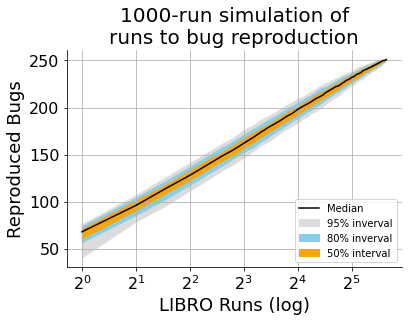

In [7]:
plt.figure(facecolor='white')

ys = key_at_n('success')
plot_x = np.arange(50)+1
plt.plot(plot_x, np.median(ys, axis=0), color='black', label='Median')
plt.fill_between(plot_x, np.quantile(ys, 0.975, axis=0), 
                 np.quantile(ys, 0.025, axis=0), 
                 label='95% inverval', color='gainsboro')
plt.fill_between(plot_x, np.quantile(ys, 0.9, axis=0), 
                 np.quantile(ys, 0.1, axis=0), 
                 label='80% inverval', color='skyblue')
plt.fill_between(plot_x, np.quantile(ys, 0.25, axis=0), 
                 np.quantile(ys, 0.75, axis=0), 
                 label='50% interval', color='orange')
plt.grid()
plt.title('1000-run simulation of\nruns to bug reproduction', fontsize=20)
plt.ylabel('Reproduced Bugs', fontsize=18)
plt.legend(loc='lower right')
plt.xlabel('LIBRO Runs (log)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xscale('log', base=2)
sns.despine(right=True, top=True)

The cell below generates the right side of Figure 3.

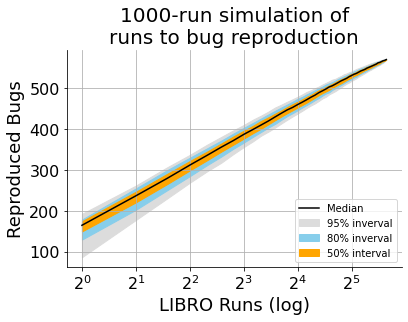

In [8]:
plt.figure(facecolor='white')

ys = key_at_n('buggy_version_failing')
plot_x = np.arange(50)+1
plt.plot(plot_x, np.median(ys, axis=0), color='black', label='Median')
plt.fill_between(plot_x, np.quantile(ys, 0.975, axis=0), 
                 np.quantile(ys, 0.025, axis=0), 
                 label='95% inverval', color='gainsboro')
plt.fill_between(plot_x, np.quantile(ys, 0.9, axis=0), 
                 np.quantile(ys, 0.1, axis=0), 
                 label='80% inverval', color='skyblue')
plt.fill_between(plot_x, np.quantile(ys, 0.25, axis=0), 
                 np.quantile(ys, 0.75, axis=0), 
                 label='50% interval', color='orange')
plt.grid()
plt.title('1000-run simulation of\nruns to bug reproduction', fontsize=20)
plt.ylabel('Reproduced Bugs', fontsize=18)
plt.legend(loc='lower right')
plt.xlabel('LIBRO Runs (log)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xscale('log', base=2)
sns.despine(right=True, top=True)

### Table 3 reproduction results

The results here stem from a random sample of other results, so values can differ from the table by a slight amount.

In [9]:
succ_ys = key_at_n('success')
fib_ys = key_at_n('buggy_version_failing')

PERCENTILES = {
    0.05: 'Two Examples (n=10, 5th percentile)', 
    0.5: 'Two Examples (n=10, median)', 
    0.95: 'Two Examples (n=10, 95th percentile)',
}
N = 10

In [10]:
tab_values = []
for p, label in PERCENTILES.items():
    succ_value = np.quantile(succ_ys, p, axis=0)[N-1]
    fib_value = np.quantile(fib_ys, p, axis=0)[N-1]
    tab_values.append({'Label': label, 'reproduced': succ_value, 'FIB': fib_value})
middle_df = pandas.DataFrame(tab_values)
middle_df

,Label,reproduced,FIB
0,"Two Examples (n=10, 5th percentile)",163.0,388.0
1,"Two Examples (n=10, median)",173.0,410.0
2,"Two Examples (n=10, 95th percentile)",184.0,429.0
